# Predicting Price of Airbnb Listings in NYC - Part 2

With data cleaning and feature engineering complete, it is time now to apply machine learning algorithms to develop an approprie price prediction model and derive futher insights from the data.

In [35]:
#import modules:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.tree            import DecisionTreeRegressor
from sklearn.neural_network  import MLPRegressor
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error
from sklearn.metrics         import r2_score

In [3]:
#read the cleaned data from a file:
df = pd.read_csv("processed_df_airbnb.csv")
target = df['log_price'].copy()
#drop unnecessary columns
df = df.drop(['Unnamed: 0','log_price'], axis=1).copy()
#strip the target column from input columns and put it in front
df = pd.concat([target, df], axis=1).copy()
#select input variable columns
nums = df.iloc[:,1:]

Let's first review the final dataframe that will be used for the analysis:

In [89]:
#first few rows of the dataframe:
df.head()

,log_price,latitude,longitude,log_(minimum_nights +1),log_(number_of_reviews +1),log_(reviews_per_month +1),log_(calculated_host_listings_count +1),log_(availability_365 +1),Allerton,Arden Heights,...,guest,comfortable,lady,girl,amazing,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,5.003946,40.64749,-73.97237,0.693147,2.302585,0.190620,1.945910,5.902633,0,0,...,0,0,0,0,0,0,1,0,0,0
1,4.488636,40.66829,-73.98779,1.609438,5.123964,0.850151,1.386294,5.752573,0,0,...,0,0,0,0,0,0,1,0,0,0
2,4.867534,40.68069,-73.97706,1.098612,4.875197,0.737164,1.945910,5.852202,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4.382027,40.67989,-73.97798,0.693147,3.688879,0.314811,1.945910,5.899897,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4.700480,40.68001,-73.97865,1.098612,4.276666,0.476234,1.945910,5.720312,0,0,...,0,0,0,0,0,0,1,0,0,0


In [90]:
#dataframe shape
print(df.shape)

(48026, 321)


In [91]:
#column names in the dataframe
df.columns.tolist()

['log_price',
 'latitude',
 'longitude',
 'log_(minimum_nights +1)',
 'log_(number_of_reviews +1)',
 'log_(reviews_per_month +1)',
 'log_(calculated_host_listings_count +1)',
 'log_(availability_365 +1)',
 'Allerton',
 'Arden Heights',
 'Arrochar',
 'Arverne',
 'Astoria',
 'Bath Beach',
 'Battery Park City',
 'Bay Ridge',
 'Bay Terrace',
 'Bay Terrace, Staten Island',
 'Baychester',
 'Bayside',
 'Bayswater',
 'Bedford-Stuyvesant',
 'Belle Harbor',
 'Bellerose',
 'Belmont',
 'Bensonhurst',
 'Bergen Beach',
 'Boerum Hill',
 'Borough Park',
 'Breezy Point',
 'Briarwood',
 'Brighton Beach',
 'Bronxdale',
 'Brooklyn Heights',
 'Brownsville',
 "Bull's Head",
 'Bushwick',
 'Cambria Heights',
 'Canarsie',
 'Carroll Gardens',
 'Castle Hill',
 'Castleton Corners',
 'Chelsea',
 'Chinatown',
 'City Island',
 'Civic Center',
 'Claremont Village',
 'Clason Point',
 'Clifton',
 'Clinton Hill',
 'Co-op City',
 'Cobble Hill',
 'College Point',
 'Columbia St',
 'Concord',
 'Concourse',
 'Concourse Villa

With one hot encoding, feature engineering and natural language processing the shape of the dataframe grew substantially. 
- Several numeric columns have been log transformed
- Individual neighborhoods have been one hot encoded along with boroughs and categorized times since the last review
- Lastly columns were created to document use of popular words in the listing name


Next, let's use the entire dataset and feed it into some of the most common regression models to see what sort of root mean square error we get:

## Experiment with several ML approaches

In [5]:
y= target
x = nums
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)

### Decision Tree Regression - kfold

In [111]:
rmse_dt=[]
dt = DecisionTreeRegressor()
kf = KFold(5, shuffle = True, random_state=1)
mse = cross_val_score(dt ,x,y, scoring = "neg_mean_squared_error", cv=kf) 
rmse = np.sqrt(np.absolute(mse))
avg_rmse = np.sum(rmse)/len(rmse)
rmse_dt.append(avg_rmse)
print("Root mean square error: " +str(round(rmse_dt[0],2)))

Root mean square error: 0.53


### XG Boost - kfold

In [115]:
rmse_xg = []
data_dmatrix = xgb.DMatrix(data=x,label=y)
params = {
              'colsample_bytree': 0.9,
              'learning_rate': 0.1,
              'max_depth': 1, 
              'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=300,
                        early_stopping_rounds=10, metrics="rmse", as_pandas=True, 
                        seed=123)
    
rmse_xg.append(cv_results["test-rmse-mean"].tolist()[-1])
print("Root mean square error: " +str(round(rmse_xg[0],2)))

[14:22:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[14:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

### Random Forest Regression - kfold

In [95]:
rmse_rf=[]
rf=RandomForestRegressor(n_estimators = 100, random_state=1,  min_samples_leaf=2)
kf = KFold(5, shuffle = True, random_state=1)
mse = cross_val_score(rf ,x,y, scoring = "neg_mean_squared_error", cv=kf) 
rmse = np.sqrt(np.absolute(mse))
avg_rmse = np.sum(rmse)/len(rmse)
rmse_rf.append(avg_rmse)
print(rmse_rf)

[0.37843357631989427]


### Neural Network  - kfold

In [96]:
rmse_nndf=[]
mlp = MLPRegressor(activation='relu', max_iter=1000)
kf = KFold(5, shuffle = True, random_state=1)
mse = cross_val_score(mlp ,x,y, scoring = "neg_mean_squared_error", cv=kf) 
rmse = np.sqrt(np.absolute(mse))
avg_rmse = np.sum(rmse)/len(rmse)
rmse_nndf.append(avg_rmse)
print(rmse_nndf)

[0.3985405113331105]


In [116]:
dt = pd.Series(rmse_dt, name ="Decision Tree")
rand = pd.Series(rmse_rf, name ="Random Forest")
xgb = pd.Series(rmse_xg, name ="XG Boost")
nn = pd.Series(rmse_nndf, name="Neural Network")
pd.concat([dt,rand,xgb,nn],axis=1)

,Decision Tree,Random Forest,XG Boost,Neural Network
0,0.531892,0.378434,0.406601,0.398541


### Comments:

Random Forest model yields the lowest RMSE, followed by Neural Netork, XGBoost and Decision Tree

Since random forest yielded the best performance, let's keep optimizing it:

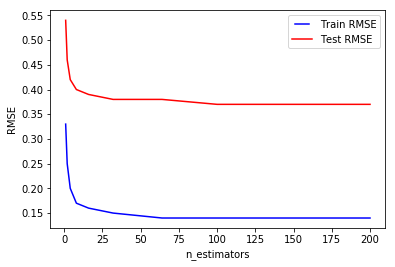

In [6]:
#optimizing number of estimators
train_results = []
test_results = []
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
for estimator in n_estimators:
    rf = RandomForestRegressor(n_estimators=estimator, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),2)
    train_results.append(rmse)
    y_pred = rf.predict(X_test)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
    test_results.append(rmse)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train RMSE')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE')
plt.xlabel('n_estimators')
plt.show()

- Clearly, the model overfits since the RMSE for train dataset is much lower then the test dataset regardless of the number of estimators
- For the best model performance on unseen data, a minimum of 100 estimators appears to be sufficient

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

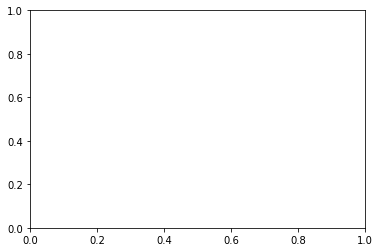

In [20]:
#optimizing max_features
train_results = []
test_results = []
max_features = ['auto','sqrt','log2']
for feature in max_features:
    rf = RandomForestRegressor(max_features=feature, n_estimators=100, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),2)
    train_results.append(rmse)
    y_pred = rf.predict(X_test)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
    test_results.append(rmse)
    
plt.bar(max_features,test_results)
plt.bar(max_features,train_results)
plt.ylabel('RMSE')
plt.xlabel('max_features, test, train')
plt.show()

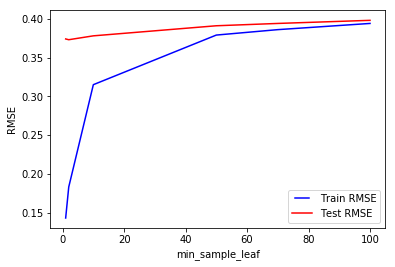

In [25]:
#optimizing min_sample_leaf
train_results = []
test_results = []
min_samples_leaf = [1,2,10,50,70,100]
for leaf in min_samples_leaf:
    rf = RandomForestRegressor(min_samples_leaf = leaf, max_features='auto', n_estimators=100, n_jobs=-1, random_state=1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),3)
    train_results.append(rmse)
    y_pred = rf.predict(X_test)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3)
    test_results.append(rmse)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leaf, train_results, 'b', label='Train RMSE')
line2, = plt.plot(min_samples_leaf, test_results, 'r', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE')
plt.xlabel('min_sample_leaf')
plt.show()

In [27]:
test_results 

[0.374, 0.373, 0.378, 0.391, 0.394, 0.398]

The graph above inticates that the model provides the best performance if the minimum samples on a leaf is at least 1

Based on the hyperparameter optimization the best conditions to choose were:
- n_estimator = 100
- max_features = 'auto'
- min_samples_leaf = 2

Next, apply these parameters to see how the overall model performs:

In [29]:
#apply the hyperparameter optmized model:
rf=RandomForestRegressor(n_estimators = 300, max_features = 'auto', min_samples_leaf=2, random_state=1)
rf.fit(X_train,y_train)
predicted = rf.predict(X_test)

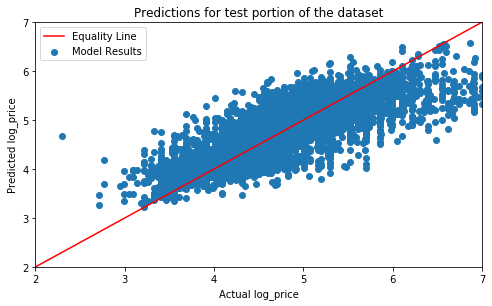

In [33]:
#plot the results of the model:
plt.figure(figsize=(8,4.5))
plt.scatter(y_test,predicted, label="Model Results")
plt.plot([2,7],[2,7], color="red", label = "Equality Line")
plt.title("Predictions for test portion of the dataset")
plt.xlim(2,7)
plt.ylim(2,7)
plt.legend()
plt.ylabel("Predicted log_price")
plt.xlabel("Actual log_price")
plt.show()

In [39]:
print("Model R2: "+str(round(r2_score(y_test,predicted),2)))

Model R2: 0.69


On the low end of the actual log_price the results tend to cluster above the line, while on the high end they tend to cluster below the line. 

This has consequences of the model underpredicting high prices and overpredicting low prices.

Next, let's take a look at what features are important in the model:

In [47]:
#derive important features
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print("Number of important features: "+str(feature_importances[feature_importances["importance"]!=0].shape[0]))
print("\nTop fifteen features by importance:")
feature_importances[feature_importances["importance"]!=0].head(15)

Number of important features: 300

Top fifteen features by importance:


,importance
Entire home/apt,0.442622
longitude,0.107504
latitude,0.098819
log_(availability_365 +1),0.053278
Manhattan,0.035903
log_(reviews_per_month +1),0.032822
log_(minimum_nights +1),0.031873
log_(number_of_reviews +1),0.027910
log_(calculated_host_listings_count +1),0.017980
studio,0.015366


### Comment:

The dataset can be further optimized by hot encoding the log_(availability_365 +1) parameter. Let's try it!

In [ ]:
plt.hist(df["log_(availability_365 +1)"],bins=30)

In [54]:
def replacement(date):
    if date <=1:
        return "avail_A"
    elif date <= 2:
        return "avail_B"
    elif date <= 3:
        return "avail_C"
    elif date <= 4:
        return "avail_D"
    elif date <= 5:
        return "avail_E"
    else:
        return "avail_F" 

    
df["log_(availability_365 +1)"]=df["log_(availability_365 +1)"].apply(lambda x: replacement(x))
# sns.boxplot(x="last_review", y=df.log_price, data=df)

#convert last review to dummies
df = pd.concat([df, pd.get_dummies(df["log_(availability_365 +1)"], drop_first=False)], axis=1)
df.drop(["log_(availability_365 +1)"],axis=1, inplace=True)

In [55]:
df.shape

(48026, 326)

In [56]:
y= target
x = nums
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)

In [57]:
rmse_rf=[]
rf=RandomForestRegressor(n_estimators = 100, random_state=1,  min_samples_leaf=2)
kf = KFold(5, shuffle = True, random_state=1)
mse = cross_val_score(rf ,x,y, scoring = "neg_mean_squared_error", cv=kf) 
rmse = np.sqrt(np.absolute(mse))
avg_rmse = np.sum(rmse)/len(rmse)
rmse_rf.append(avg_rmse)
print(rmse_rf)

[0.37843357631989427]


No improvement after one hot encoding

### Private v. Shared v. Home

In [51]:
#separate datasets
private = df[df["Private room"]==1].copy()
shared = df[df["Shared room"]==1].copy()
homes = df[df["Entire home/apt"]==1].copy()

#define random forest function
def random_forest(df):
    target = df['log_price'].copy()
    #select input variable columns
    nums = df.iloc[:,1:]

    #split the data into test and train
    y= target
    x = nums
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)

    rmse_rf=[]
    rf=RandomForestRegressor(n_estimators = 300, max_features = 'auto', min_samples_leaf=1, random_state=1)
    kf = KFold(5, shuffle = True, random_state=1)
    mse = cross_val_score(rf ,x,y, scoring = "neg_mean_squared_error", cv=kf) 
    rmse = np.sqrt(np.absolute(mse))
    avg_rmse = np.sum(rmse)/len(rmse)
    rmse_rf.append(avg_rmse)
    return rmse_rf
    
private_rmse = random_forest(private)
shared_rmse = random_forest(shared)
home_rmse = random_forest(homes)

print("\nShared RMSE: "+str(round(shared_rmse[0],3)))
print("Private RMSE: "+str(round(private_rmse[0],3)))
print("Home RMSE: "+str(round(home_rmse[0],3)))

NameError: name 'home' is not defined

There are relatively few shared rooms in the dataset, which likely contributes to the largest RMSE.


Summarize

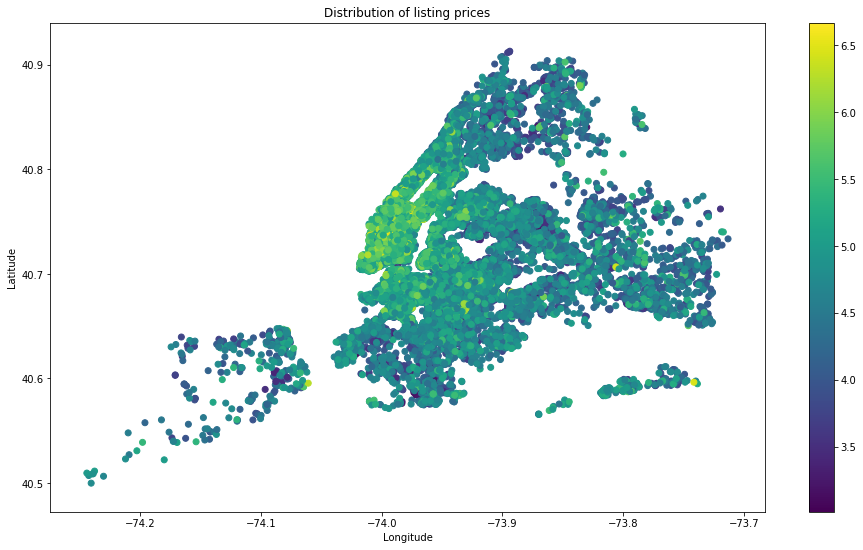

In [81]:
y = df.latitude
x = df.longitude
p = prediction_all
plt.figure(figsize=(16,9))
plt.scatter(x,y,c=p,cmap='viridis')
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribution of listing prices")
plt.show()